In [2]:
# prompt: mount the folder in which the ipynb is located

import os
from google.colab import drive

drive.mount('/content/drive')

# Get the current working directory
# current_directory = os.getcwd()

%cd ./drive/MyDrive/DeepL_BI_codes/project/

# Verify the change
print(f"Current working directory: {os.getcwd()}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DeepL_BI_codes/project
Current working directory: /content/drive/MyDrive/DeepL_BI_codes/project


In [ ]:
# prompt: unzip original files.zip

# !unzip OriginalFiles.zip > /dev/null


In [3]:
import os
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
import os
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
warnings.filterwarnings(action="ignore")

# Inline plotting (optional in Colab, but safe to include)
%matplotlib inline

# TensorFlow/Keras and model components
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Conv2D, MaxPooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import sklearn.metrics as metrics

# Learning rate schedule
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [5]:
# Define the base directory where AugmentedAlzheimerDataset is located
base_dir = os.path.join("AugmentedAlzheimerDataset")
# base_dir = os.path.join("data", "OriginalDataset")

# Define paths for each category
mild_demented_path = os.path.join(base_dir, "MildDemented")
moderate_demented_path = os.path.join(base_dir, "ModerateDemented")
non_demented_path = os.path.join(base_dir, "NonDemented")
very_mild_demented_path = os.path.join(base_dir, "VeryMildDemented")

# Create variables with lists of image file paths for each category
mild_demented_images = glob(os.path.join(mild_demented_path, "*"))
moderate_demented_images = glob(os.path.join(moderate_demented_path, "*"))
non_demented_images = glob(os.path.join(non_demented_path, "*"))
very_mild_demented_images = glob(os.path.join(very_mild_demented_path, "*"))

# Optionally, print the number of images found in each folder
print("Mild Demented:", len(mild_demented_images))
print("Moderate Demented:", len(moderate_demented_images))
print("Non Demented:", len(non_demented_images))
print("Very Mild Demented:", len(very_mild_demented_images))

Mild Demented: 8950
Moderate Demented: 6308
Non Demented: 9548
Very Mild Demented: 5971


In [6]:
data = []

data.extend([(img, "MildDemented") for img in mild_demented_images])
data.extend([(img, "ModerateDemented") for img in moderate_demented_images])
data.extend([(img, "NonDemented") for img in non_demented_images])
data.extend([(img, "VeryMildDemented") for img in very_mild_demented_images])

print("Total images:", len(data))

Total images: 30777


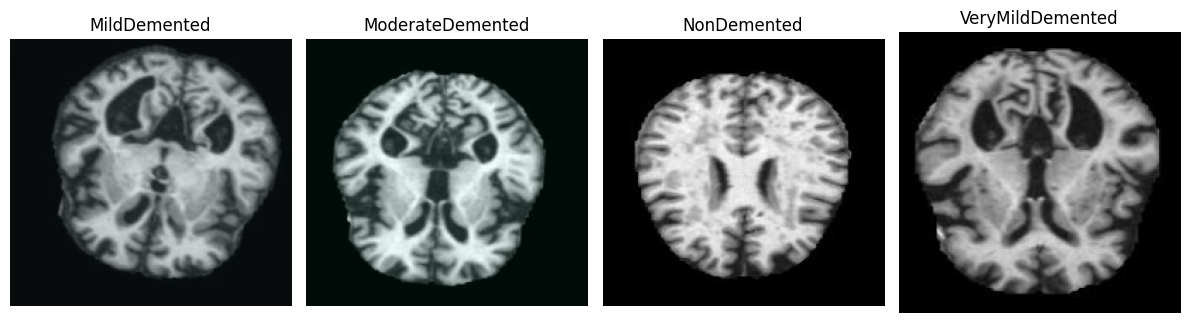

In [7]:
# Define the four categories
categories = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]

# For each category, select the first image found in data
samples = {cat: next(img for img, label in data if label == cat) for cat in categories}

plt.figure(figsize=(12, 4))
for i, cat in enumerate(categories):
    # Open the image and plot it
    img = Image.open(samples[cat])
    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.title(cat)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [8]:
'''
df = pd.DataFrame(data, columns=['filepaths', 'labels'])

train_images, test_images = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df['labels']
)
train_set, val_set = train_test_split(
    train_images, test_size=0.2, random_state=42, stratify=train_images['labels']
)
print(train_images.shape)

print(train_set.shape)
print(val_set.shape)

print(test_images.shape)
'''

"\ndf = pd.DataFrame(data, columns=['filepaths', 'labels'])\n\ntrain_images, test_images = train_test_split(\n    df, test_size=0.3, random_state=42, stratify=df['labels']\n)\ntrain_set, val_set = train_test_split(\n    train_images, test_size=0.2, random_state=42, stratify=train_images['labels']\n)\nprint(train_images.shape)\n\nprint(train_set.shape)\nprint(val_set.shape)\n\nprint(test_images.shape)\n"

In [9]:
# Create DataFrame
df = pd.DataFrame(data, columns=['filepaths', 'labels'])

# Shuffle the full dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Define how many samples you want
num_train_samples = 1000   # 👈 Total samples used for train + val
num_test_samples = 400     # 👈 Total samples used for test

# Check total is within dataset size
assert num_train_samples + num_test_samples <= len(df), \
    "Requested train + test size exceeds dataset size."

# Step 1: Sample training subset (stratified)
train_val_subset = df.groupby('labels', group_keys=False).apply(
    lambda x: x.sample(int(num_train_samples * len(x) / len(df)), random_state=42)
).reset_index(drop=True)

# Step 2: Remove train_val samples from df and sample test set (stratified)
remaining = df.drop(train_val_subset.index).reset_index(drop=True)
test_images = remaining.groupby('labels', group_keys=False).apply(
    lambda x: x.sample(int(num_test_samples * len(x) / len(df)), random_state=42)
).reset_index(drop=True)

# Step 3: Split training subset into train and validation sets (e.g., 80/20)
train_set, val_set = train_test_split(
    train_val_subset,
    test_size=0.2,
    random_state=42,
    stratify=train_val_subset['labels']
)

# Print final shapes
print("Train set:", train_set.shape)
print("Validation set:", val_set.shape)
print("Test set:", test_images.shape)

Train set: (798, 2)
Validation set: (200, 2)
Test set: (386, 2)


In [10]:
# Use MobileNetV2 preprocessing and set up data generators
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

# Training data generator
train = image_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(244, 244),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=32,
    shuffle=True  # Can set to True for training
)

# Validation data generator
val = image_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(244, 244),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

# Testing data generator
test = image_gen.flow_from_dataframe(
    dataframe=test_images,
    x_col="filepaths",
    y_col="labels",
    target_size=(244, 244),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

Found 798 validated image filenames belonging to 4 classes.
Found 200 validated image filenames belonging to 4 classes.
Found 386 validated image filenames belonging to 4 classes.


# EfficientNetB7

In [ ]:
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import EfficientNetB7

# Define input image shape
img_shape = (244, 244, 3)

# Load the pre-trained EfficientNetB7 model without the top classification layer
base_model = EfficientNetB7(
    include_top=False,         # Do not include the top classification layer
    weights="imagenet",        # Use pre-trained ImageNet weights
    input_shape=img_shape,     # Input shape
    pooling='max'              # Global max pooling after conv base
)

In [ ]:
base_model.trainable = True

# Flag to start fine-tuning
set_trainable = False

# Unfreeze layers from a specific point onwards
for layer in base_model.layers:
    if layer.name == 'block6a_expand_conv':  # You can change this layer to whichever layer you want to unfreeze
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
EfficientNetB7_model = Sequential([
    tf.keras.layers.InputLayer(input_shape=img_shape),
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

EfficientNetB7_model.compile(
    Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

EfficientNetB7_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 2560)           │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,426,011 (245.77 MB)

 Trainable params: 51,795,452 (197.58 MB)

 Non-trainable params: 12,630,559 (48.18 MB)

In [ ]:
# List all available physical devices
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    print("GPU is available:")
    for device in physical_devices:
        print(f"  - {device}")
else:
    print("GPU is NOT available. Using CPU.")

from tensorflow.python.client import device_lib

# Print available devices
print("Available devices:")
for device in device_lib.list_local_devices():
    print(f"  - {device.name} ({device.device_type})")

GPU is available:
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Available devices:
  - /device:CPU:0 (CPU)
  - /device:GPU:0 (GPU)


In [ ]:
# Move the model to the GPU if available
with tf.device('/GPU:0'): # Or '/GPU:1' etc. if you have multiple GPUs. If no GPU, defaults to CPU.
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )
    history = EfficientNetB7_model.fit(
        train,
        epochs=50,
        validation_data=val,
        callbacks=[early_stopping, annealer]
    )


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 630ms/step - accuracy: 0.7691 - loss: 0.6006 - val_accuracy: 0.6400 - val_loss: 0.9118 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 573ms/step - accuracy: 0.7703 - loss: 0.5254 - val_accuracy: 0.6550 - val_loss: 0.9422 - learning_rate: 9.5000e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 570ms/step - accuracy: 0.7911 - loss: 0.4921 - val_accuracy: 0.6650 - val_loss: 1.0440 - learning_rate: 9.0250e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 581ms/step - accuracy: 0.7887 - loss: 0.5869 - val_accuracy: 0.6850 - val_loss: 0.9037 - learning_rate: 8.5737e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 564ms/step - accuracy: 0.8442 - loss: 0.3894 - val_accuracy: 0.7250 - val_loss: 0.9400 - learning_rate: 8.1451e-04
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 565ms/step - accuracy: 0.8610 - loss: 0.3721 - val_accuracy: 0.6700 - val_loss: 1.0149 - learning_rate: 7.7378e-04
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 598ms/step - accurac

In [ ]:
train_loss, train_accuracy =  EfficientNetB7_model.evaluate(train)
print(f'\nTrain loss: {train_loss:.2f}')
print(f'Train Accuracy: {train_accuracy*100:.2f} %')

val_loss, val_accuracy =  EfficientNetB7_model.evaluate(val)
print(f'\nvalidation loss: {val_loss:.2f}')
print(f'Validation Accuracy: {val_accuracy*100:.2f} %')

test_loss, test_accuracy =  EfficientNetB7_model.evaluate(test)
print(f'\ntest loss: {test_loss:.2f}')
print(f'test Accuracy: {test_accuracy*100:.2f} %')

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - accuracy: 0.9537 - loss: 0.1959

Train loss: 0.21
Train Accuracy: 93.86 %
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - accuracy: 0.6531 - loss: 0.9946

validation loss: 0.90
Validation Accuracy: 68.50 %
13/13 ━━━━━━━━━━━━━━━━━━━━ 225s 19s/step - accuracy: 0.7103 - loss: 0.8577

test loss: 0.97
test Accuracy: 67.36 %


In [ ]:
result = EfficientNetB7_model.evaluate(test, verbose=1)
print(result)

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step - accuracy: 0.7103 - loss: 0.8577
[0.9662672281265259, 0.6735751032829285]


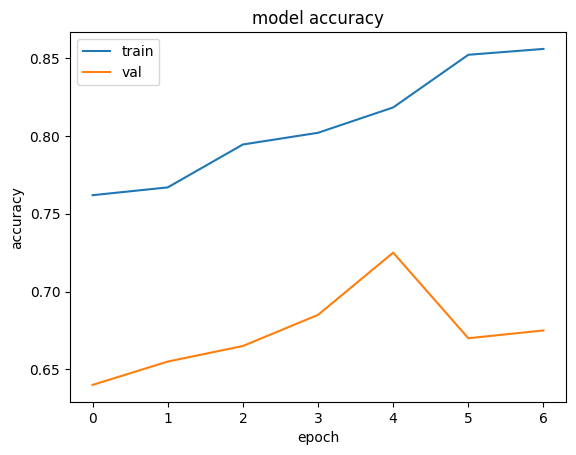

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

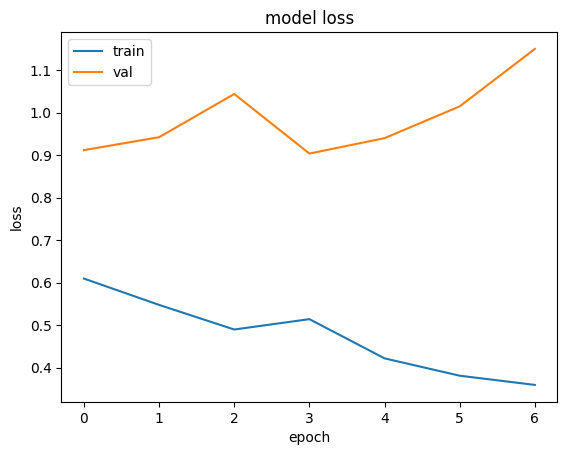

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

test_hat =  EfficientNetB7_model.predict(test)
test_hat = np.argmax(test_hat, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_report = [labels[k] for k in test_hat]

y_test = test_images.labels
print(classification_report(y_test, pred_report))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred_report)*100))

13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step
                  precision    recall  f1-score   support

    MildDemented       0.67      0.68      0.67       112
ModerateDemented       0.92      0.92      0.92        79
     NonDemented       0.63      0.78      0.69       120
VeryMildDemented       0.40      0.24      0.30        75

        accuracy                           0.67       386
       macro avg       0.65      0.65      0.65       386
    weighted avg       0.66      0.67      0.66       386

Accuracy of the Model: 67.4%


# EfficientNetB6

In [10]:
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import EfficientNetB6

# Define input image shape
img_shape = (244, 244, 3)

# Load the pre-trained EfficientNetB7 model without the top classification layer
base_model = EfficientNetB6(
    include_top=False,         # Do not include the top classification layer
    weights="imagenet",        # Use pre-trained ImageNet weights
    input_shape=img_shape,     # Input shape
    pooling='max'              # Global max pooling after conv base
)

165234480/165234480 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
base_model.trainable = True

# Flag to start fine-tuning
set_trainable = False

# Unfreeze layers from a specific point onwards
for layer in base_model.layers:
    if layer.name == 'block6a_expand_conv':  # You can change this layer to whichever layer you want to unfreeze
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [12]:
EfficientNetB6_model = Sequential([
    tf.keras.layers.InputLayer(input_shape=img_shape),
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

EfficientNetB6_model.compile(
    Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

EfficientNetB6_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb6 (Functional)     │ (None, 2304)           │    40,960,143 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,255,699 (157.38 MB)

 Trainable params: 33,150,808 (126.46 MB)

 Non-trainable params: 8,104,891 (30.92 MB)

In [13]:
# List all available physical devices
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    print("GPU is available:")
    for device in physical_devices:
        print(f"  - {device}")
else:
    print("GPU is NOT available. Using CPU.")

from tensorflow.python.client import device_lib

# Print available devices
print("Available devices:")
for device in device_lib.list_local_devices():
    print(f"  - {device.name} ({device.device_type})")

GPU is available:
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Available devices:
  - /device:CPU:0 (CPU)
  - /device:GPU:0 (GPU)


In [14]:
# Move the model to the GPU if available
with tf.device('/GPU:0'): # Or '/GPU:1' etc. if you have multiple GPUs. If no GPU, defaults to CPU.
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )
    history = EfficientNetB6_model.fit(
        train,
        epochs=50,
        validation_data=val,
        callbacks=[early_stopping, annealer]
    )


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 590s 19s/step - accuracy: 0.3363 - loss: 3.4329 - val_accuracy: 0.3150 - val_loss: 1.3781 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 432ms/step - accuracy: 0.4419 - loss: 1.2223 - val_accuracy: 0.4350 - val_loss: 1.3364 - learning_rate: 9.5000e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 435ms/step - accuracy: 0.5539 - loss: 1.0462 - val_accuracy: 0.3950 - val_loss: 1.3101 - learning_rate: 9.0250e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 475ms/step - accuracy: 0.5915 - loss: 0.9870 - val_accuracy: 0.4050 - val_loss: 1.2692 - learning_rate: 8.5737e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 422ms/step - accuracy: 0.6375 - loss: 0.8639 - val_accuracy: 0.4850 - val_loss: 1.1975 - learning_rate: 8.1451e-04
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 420ms/step - accuracy: 0.6512 - loss: 0.8239 - val_accuracy: 0.4850 - val_loss: 1.1154 - learning_rate: 7.7378e-04
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 422ms/step - accuracy

In [15]:
train_loss, train_accuracy =  EfficientNetB6_model.evaluate(train)
print(f'\nTrain loss: {train_loss:.2f}')
print(f'Train Accuracy: {train_accuracy*100:.2f} %')

val_loss, val_accuracy =  EfficientNetB6_model.evaluate(val)
print(f'\nvalidation loss: {val_loss:.2f}')
print(f'Validation Accuracy: {val_accuracy*100:.2f} %')

test_loss, test_accuracy =  EfficientNetB6_model.evaluate(test)
print(f'\ntest loss: {test_loss:.2f}')
print(f'test Accuracy: {test_accuracy*100:.2f} %')

25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 518ms/step - accuracy: 0.8902 - loss: 0.3063

Train loss: 0.30
Train Accuracy: 89.47 %
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.5867 - loss: 0.9046

validation loss: 0.87
Validation Accuracy: 59.00 %
13/13 ━━━━━━━━━━━━━━━━━━━━ 138s 11s/step - accuracy: 0.6337 - loss: 0.8080

test loss: 0.87
test Accuracy: 59.59 %


In [16]:
result = EfficientNetB6_model.evaluate(test, verbose=1)
print(result)

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.6337 - loss: 0.8080
[0.8652011752128601, 0.5958549380302429]


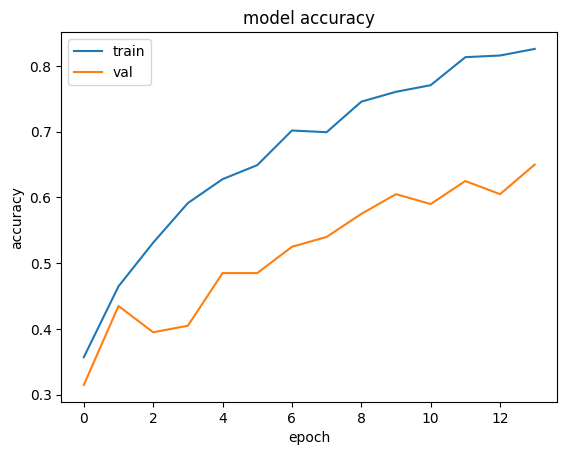

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

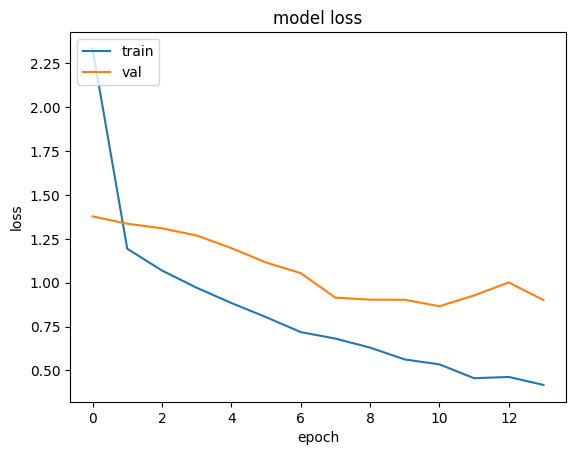

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score

test_hat =  EfficientNetB6_model.predict(test)
test_hat = np.argmax(test_hat, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_report = [labels[k] for k in test_hat]

y_test = test_images.labels
print(classification_report(y_test, pred_report))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred_report)*100))

13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step
                  precision    recall  f1-score   support

    MildDemented       0.52      0.54      0.53       112
ModerateDemented       0.94      0.97      0.96        79
     NonDemented       0.59      0.68      0.63       120
VeryMildDemented       0.24      0.16      0.19        75

        accuracy                           0.60       386
       macro avg       0.57      0.59      0.58       386
    weighted avg       0.57      0.60      0.58       386

Accuracy of the Model: 59.6%


# EfficientNetB5

In [21]:
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import EfficientNetB5

# Define input image shape
img_shape = (244, 244, 3)

# Load the pre-trained EfficientNetB7 model without the top classification layer
base_model = EfficientNetB5(
    include_top=False,         # Do not include the top classification layer
    weights="imagenet",        # Use pre-trained ImageNet weights
    input_shape=img_shape,     # Input shape
    pooling='max'              # Global max pooling after conv base
)

115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [22]:
base_model.trainable = True

# Flag to start fine-tuning
set_trainable = False

# Unfreeze layers from a specific point onwards
for layer in base_model.layers:
    if layer.name == 'block6a_expand_conv':  # You can change this layer to whichever layer you want to unfreeze
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [23]:
EfficientNetB5_model = Sequential([
    tf.keras.layers.InputLayer(input_shape=img_shape),
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

EfficientNetB5_model.compile(
    Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

EfficientNetB5_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb6 (Functional)     │ (None, 2304)           │    40,960,143 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,557,317 (410.30 MB)

 Trainable params: 33,150,808 (126.46 MB)

 Non-trainable params: 8,104,891 (30.92 MB)

 Optimizer params: 66,301,618 (252.92 MB)

In [24]:
# List all available physical devices
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    print("GPU is available:")
    for device in physical_devices:
        print(f"  - {device}")
else:
    print("GPU is NOT available. Using CPU.")

from tensorflow.python.client import device_lib

# Print available devices
print("Available devices:")
for device in device_lib.list_local_devices():
    print(f"  - {device.name} ({device.device_type})")

GPU is available:
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Available devices:
  - /device:CPU:0 (CPU)
  - /device:GPU:0 (GPU)


In [25]:
# Move the model to the GPU if available
with tf.device('/GPU:0'): # Or '/GPU:1' etc. if you have multiple GPUs. If no GPU, defaults to CPU.
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )
    history = EfficientNetB5_model.fit(
        train,
        epochs=50,
        validation_data=val,
        callbacks=[early_stopping, annealer]
    )


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 188s 4s/step - accuracy: 0.3000 - loss: 3.4216 - val_accuracy: 0.3300 - val_loss: 1.3762 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 413ms/step - accuracy: 0.4118 - loss: 1.2730 - val_accuracy: 0.3650 - val_loss: 1.3532 - learning_rate: 9.5000e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 412ms/step - accuracy: 0.5239 - loss: 1.1244 - val_accuracy: 0.3550 - val_loss: 1.3450 - learning_rate: 9.0250e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 308ms/step - accuracy: 0.5442 - loss: 1.0787 - val_accuracy: 0.4100 - val_loss: 1.3128 - learning_rate: 8.5737e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 314ms/step - accuracy: 0.5898 - loss: 0.9687 - val_accuracy: 0.4550 - val_loss: 1.2614 - learning_rate: 8.1451e-04
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 306ms/step - accuracy: 0.6406 - loss: 0.9033 - val_accuracy: 0.4800 - val_loss: 1.2115 - learning_rate: 7.7378e-04
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 312ms/step - accuracy: 0.6

In [26]:
train_loss, train_accuracy =  EfficientNetB5_model.evaluate(train)
print(f'\nTrain loss: {train_loss:.2f}')
print(f'Train Accuracy: {train_accuracy*100:.2f} %')

val_loss, val_accuracy =  EfficientNetB5_model.evaluate(val)
print(f'\nvalidation loss: {val_loss:.2f}')
print(f'Validation Accuracy: {val_accuracy*100:.2f} %')

test_loss, test_accuracy =  EfficientNetB5_model.evaluate(test)
print(f'\ntest loss: {test_loss:.2f}')
print(f'test Accuracy: {test_accuracy*100:.2f} %')

25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 415ms/step - accuracy: 0.8866 - loss: 0.3843

Train loss: 0.40
Train Accuracy: 88.97 %
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.5922 - loss: 0.9505

validation loss: 0.88
Validation Accuracy: 62.50 %
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 777ms/step - accuracy: 0.6794 - loss: 0.7780

test loss: 0.84
test Accuracy: 65.80 %


In [27]:
result = EfficientNetB5_model.evaluate(test, verbose=1)
print(result)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.6794 - loss: 0.7780
[0.838301956653595, 0.6580311059951782]


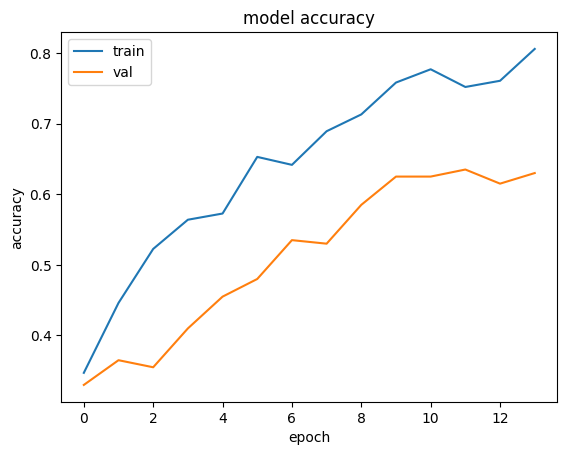

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

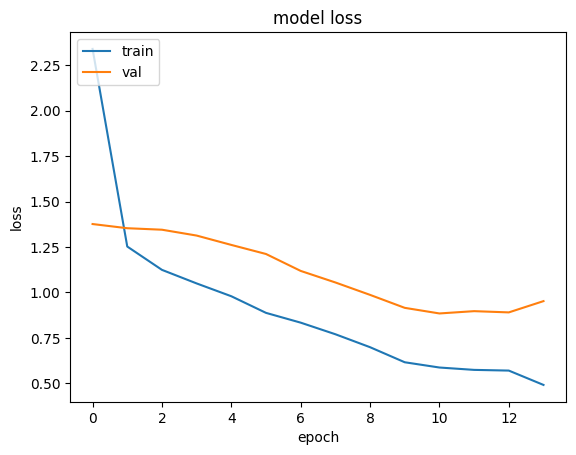

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score

test_hat =  EfficientNetB5_model.predict(test)
test_hat = np.argmax(test_hat, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_report = [labels[k] for k in test_hat]

y_test = test_images.labels
print(classification_report(y_test, pred_report))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred_report)*100))

13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step
                  precision    recall  f1-score   support

    MildDemented       0.61      0.60      0.60       112
ModerateDemented       0.95      0.96      0.96        79
     NonDemented       0.64      0.73      0.68       120
VeryMildDemented       0.39      0.31      0.34        75

        accuracy                           0.66       386
       macro avg       0.65      0.65      0.65       386
    weighted avg       0.65      0.66      0.65       386

Accuracy of the Model: 65.8%


# EfficientNetB4

In [32]:
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import EfficientNetB4

# Define input image shape
img_shape = (244, 244, 3)

# Load the pre-trained EfficientNetB7 model without the top classification layer
base_model = EfficientNetB4(
    include_top=False,         # Do not include the top classification layer
    weights="imagenet",        # Use pre-trained ImageNet weights
    input_shape=img_shape,     # Input shape
    pooling='max'              # Global max pooling after conv base
)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [33]:
base_model.trainable = True

# Flag to start fine-tuning
set_trainable = False

# Unfreeze layers from a specific point onwards
for layer in base_model.layers:
    if layer.name == 'block6a_expand_conv':  # You can change this layer to whichever layer you want to unfreeze
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [34]:
EfficientNetB4_model = Sequential([
    tf.keras.layers.InputLayer(input_shape=img_shape),
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

EfficientNetB4_model.compile(
    Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

EfficientNetB4_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 1792)           │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       229,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,903,843 (68.30 MB)

 Trainable params: 14,142,652 (53.95 MB)

 Non-trainable params: 3,761,191 (14.35 MB)

In [35]:
# List all available physical devices
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    print("GPU is available:")
    for device in physical_devices:
        print(f"  - {device}")
else:
    print("GPU is NOT available. Using CPU.")

from tensorflow.python.client import device_lib

# Print available devices
print("Available devices:")
for device in device_lib.list_local_devices():
    print(f"  - {device.name} ({device.device_type})")

GPU is available:
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Available devices:
  - /device:CPU:0 (CPU)
  - /device:GPU:0 (GPU)


In [36]:
# Move the model to the GPU if available
with tf.device('/GPU:0'): # Or '/GPU:1' etc. if you have multiple GPUs. If no GPU, defaults to CPU.
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )
    history = EfficientNetB4_model.fit(
        train,
        epochs=50,
        validation_data=val,
        callbacks=[early_stopping, annealer]
    )


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.2797 - loss: 4.8456 - val_accuracy: 0.3100 - val_loss: 1.3982 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 249ms/step - accuracy: 0.4058 - loss: 1.3083 - val_accuracy: 0.3100 - val_loss: 1.3738 - learning_rate: 9.5000e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step - accuracy: 0.3885 - loss: 1.2650 - val_accuracy: 0.3100 - val_loss: 1.3660 - learning_rate: 9.0250e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step - accuracy: 0.4585 - loss: 1.1730 - val_accuracy: 0.2950 - val_loss: 1.3482 - learning_rate: 8.5737e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - accuracy: 0.4875 - loss: 1.1759 - val_accuracy: 0.3600 - val_loss: 1.3372 - learning_rate: 8.1451e-04
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - accuracy: 0.5493 - loss: 1.0577 - val_accuracy: 0.3900 - val_loss: 1.3296 - learning_rate: 7.7378e-04
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step - accuracy: 0.504

In [37]:
train_loss, train_accuracy =  EfficientNetB4_model.evaluate(train)
print(f'\nTrain loss: {train_loss:.2f}')
print(f'Train Accuracy: {train_accuracy*100:.2f} %')

val_loss, val_accuracy =  EfficientNetB4_model.evaluate(val)
print(f'\nvalidation loss: {val_loss:.2f}')
print(f'Validation Accuracy: {val_accuracy*100:.2f} %')

test_loss, test_accuracy =  EfficientNetB4_model.evaluate(test)
print(f'\ntest loss: {test_loss:.2f}')
print(f'test Accuracy: {test_accuracy*100:.2f} %')

25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 348ms/step - accuracy: 0.8858 - loss: 0.3134

Train loss: 0.32
Train Accuracy: 88.22 %
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.5986 - loss: 1.0546

validation loss: 0.97
Validation Accuracy: 61.50 %
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 634ms/step - accuracy: 0.6869 - loss: 0.8113

test loss: 0.91
test Accuracy: 63.21 %


In [38]:
result = EfficientNetB4_model.evaluate(test, verbose=1)
print(result)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.6869 - loss: 0.8113
[0.9127601981163025, 0.6321243643760681]


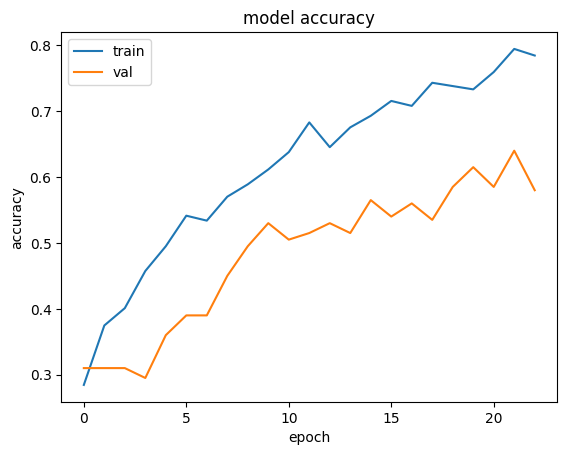

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

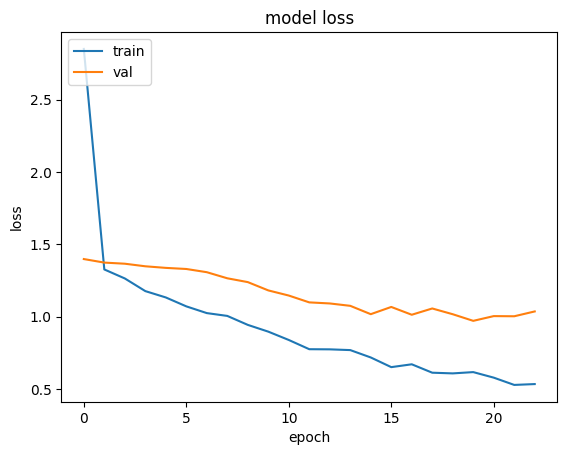

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [41]:
from sklearn.metrics import confusion_matrix, accuracy_score

test_hat =  EfficientNetB4_model.predict(test)
test_hat = np.argmax(test_hat, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_report = [labels[k] for k in test_hat]

y_test = test_images.labels
print(classification_report(y_test, pred_report))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred_report)*100))

13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 996ms/step
                  precision    recall  f1-score   support

    MildDemented       0.55      0.65      0.60       112
ModerateDemented       0.79      0.96      0.87        79
     NonDemented       0.68      0.69      0.69       120
VeryMildDemented       0.34      0.16      0.22        75

        accuracy                           0.63       386
       macro avg       0.59      0.62      0.59       386
    weighted avg       0.60      0.63      0.61       386

Accuracy of the Model: 63.2%


# EfficientNetB3

In [42]:
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import EfficientNetB3

# Define input image shape
img_shape = (244, 244, 3)

# Load the pre-trained EfficientNetB7 model without the top classification layer
base_model = EfficientNetB3(
    include_top=False,         # Do not include the top classification layer
    weights="imagenet",        # Use pre-trained ImageNet weights
    input_shape=img_shape,     # Input shape
    pooling='max'              # Global max pooling after conv base
)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [43]:
base_model.trainable = True

# Flag to start fine-tuning
set_trainable = False

# Unfreeze layers from a specific point onwards
for layer in base_model.layers:
    if layer.name == 'block6a_expand_conv':  # You can change this layer to whichever layer you want to unfreeze
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [44]:
EfficientNetB3_model = Sequential([
    tf.keras.layers.InputLayer(input_shape=img_shape),
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

EfficientNetB3_model.compile(
    Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

EfficientNetB3_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,980,787 (41.89 MB)

 Trainable params: 8,703,330 (33.20 MB)

 Non-trainable params: 2,277,457 (8.69 MB)

In [45]:
# List all available physical devices
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    print("GPU is available:")
    for device in physical_devices:
        print(f"  - {device}")
else:
    print("GPU is NOT available. Using CPU.")

from tensorflow.python.client import device_lib

# Print available devices
print("Available devices:")
for device in device_lib.list_local_devices():
    print(f"  - {device.name} ({device.device_type})")

GPU is available:
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Available devices:
  - /device:CPU:0 (CPU)
  - /device:GPU:0 (GPU)


In [46]:
# Move the model to the GPU if available
with tf.device('/GPU:0'): # Or '/GPU:1' etc. if you have multiple GPUs. If no GPU, defaults to CPU.
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )
    history = EfficientNetB3_model.fit(
        train,
        epochs=50,
        validation_data=val,
        callbacks=[early_stopping, annealer]
    )


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.3342 - loss: 5.3116 - val_accuracy: 0.2650 - val_loss: 1.3987 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - accuracy: 0.4245 - loss: 1.3481 - val_accuracy: 0.2000 - val_loss: 1.3872 - learning_rate: 9.5000e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - accuracy: 0.3822 - loss: 1.2830 - val_accuracy: 0.2150 - val_loss: 1.3951 - learning_rate: 9.0250e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.4817 - loss: 1.1737 - val_accuracy: 0.2700 - val_loss: 1.3899 - learning_rate: 8.5737e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.4758 - loss: 1.1697 - val_accuracy: 0.2750 - val_loss: 1.3830 - learning_rate: 8.1451e-04
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - accuracy: 0.5189 - loss: 1.0914 - val_accuracy: 0.3150 - val_loss: 1.3605 - learning_rate: 7.7378e-04
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.526

In [47]:
train_loss, train_accuracy =  EfficientNetB3_model.evaluate(train)
print(f'\nTrain loss: {train_loss:.2f}')
print(f'Train Accuracy: {train_accuracy*100:.2f} %')

val_loss, val_accuracy =  EfficientNetB3_model.evaluate(val)
print(f'\nvalidation loss: {val_loss:.2f}')
print(f'Validation Accuracy: {val_accuracy*100:.2f} %')

test_loss, test_accuracy =  EfficientNetB3_model.evaluate(test)
print(f'\ntest loss: {test_loss:.2f}')
print(f'test Accuracy: {test_accuracy*100:.2f} %')

25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 370ms/step - accuracy: 0.8435 - loss: 0.4348

Train loss: 0.43
Train Accuracy: 85.21 %
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.6080 - loss: 0.8707

validation loss: 0.83
Validation Accuracy: 62.50 %
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 642ms/step - accuracy: 0.6792 - loss: 0.7518

test loss: 0.83
test Accuracy: 61.92 %


In [48]:
result = EfficientNetB3_model.evaluate(test, verbose=1)
print(result)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.6792 - loss: 0.7518
[0.8312531113624573, 0.6191709637641907]


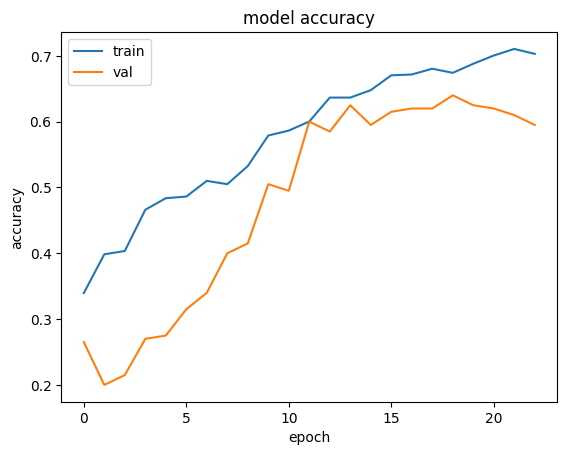

In [49]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

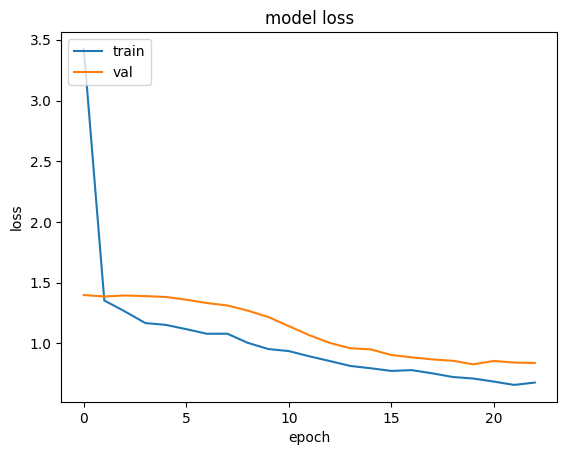

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [51]:
from sklearn.metrics import confusion_matrix, accuracy_score

test_hat =  EfficientNetB3_model.predict(test)
test_hat = np.argmax(test_hat, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_report = [labels[k] for k in test_hat]

y_test = test_images.labels
print(classification_report(y_test, pred_report))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred_report)*100))

13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 878ms/step
                  precision    recall  f1-score   support

    MildDemented       0.60      0.63      0.61       112
ModerateDemented       0.84      0.95      0.89        79
     NonDemented       0.66      0.64      0.65       120
VeryMildDemented       0.26      0.21      0.23        75

        accuracy                           0.62       386
       macro avg       0.59      0.61      0.60       386
    weighted avg       0.60      0.62      0.61       386

Accuracy of the Model: 61.9%


# EfficientNetB2

In [11]:
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import EfficientNetB2

# Define input image shape
img_shape = (244, 244, 3)

# Load the pre-trained EfficientNetB2 model without the top classification layer
base_model = EfficientNetB2(
    include_top=False,         # Do not include the top classification layer
    weights="imagenet",        # Use pre-trained ImageNet weights
    input_shape=img_shape,     # Input shape
    pooling='max'              # Global max pooling after conv base
)

In [12]:
base_model.trainable = True

# Flag to start fine-tuning
set_trainable = False

# Unfreeze layers from a specific point onwards
for layer in base_model.layers:
    if layer.name == 'block6a_expand_conv':  # You can change this layer to whichever layer you want to unfreeze
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [13]:
EfficientNetB2_model = Sequential([
    tf.keras.layers.InputLayer(input_shape=img_shape),
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

EfficientNetB2_model.compile(
    Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

EfficientNetB2_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb2 (Functional)     │ (None, 1408)           │     7,768,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       180,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,949,437 (30.32 MB)

 Trainable params: 6,463,998 (24.66 MB)

 Non-trainable params: 1,485,439 (5.67 MB)

In [14]:
# List all available physical devices
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    print("GPU is available:")
    for device in physical_devices:
        print(f"  - {device}")
else:
    print("GPU is NOT available. Using CPU.")

from tensorflow.python.client import device_lib

# Print available devices
print("Available devices:")
for device in device_lib.list_local_devices():
    print(f"  - {device.name} ({device.device_type})")

GPU is available:
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Available devices:
  - /device:CPU:0 (CPU)
  - /device:GPU:0 (GPU)


In [15]:
# Move the model to the GPU if available
with tf.device('/GPU:0'): # Or '/GPU:1' etc. if you have multiple GPUs. If no GPU, defaults to CPU.
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )
    history = EfficientNetB2_model.fit(
        train,
        epochs=50,
        validation_data=val,
        callbacks=[early_stopping, annealer]
    )


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 270s 8s/step - accuracy: 0.2642 - loss: 5.6279 - val_accuracy: 0.1900 - val_loss: 1.3949 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.2966 - loss: 1.5470 - val_accuracy: 0.3200 - val_loss: 1.3867 - learning_rate: 9.5000e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.3477 - loss: 1.3583 - val_accuracy: 0.3050 - val_loss: 1.3773 - learning_rate: 9.0250e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.3323 - loss: 1.3424 - val_accuracy: 0.3550 - val_loss: 1.3709 - learning_rate: 8.5737e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.4057 - loss: 1.2833 - val_accuracy: 0.3350 - val_loss: 1.3718 - learning_rate: 8.1451e-04
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 0.3875 - loss: 1.2856 - val_accuracy: 0.2750 - val_loss: 1.3813 - learning_rate: 7.7378e-04
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.387

In [16]:
train_loss, train_accuracy =  EfficientNetB2_model.evaluate(train)
print(f'\nTrain loss: {train_loss:.2f}')
print(f'Train Accuracy: {train_accuracy*100:.2f} %')

val_loss, val_accuracy =  EfficientNetB2_model.evaluate(val)
print(f'\nvalidation loss: {val_loss:.2f}')
print(f'Validation Accuracy: {val_accuracy*100:.2f} %')

test_loss, test_accuracy =  EfficientNetB2_model.evaluate(test)
print(f'\ntest loss: {test_loss:.2f}')
print(f'test Accuracy: {test_accuracy*100:.2f} %')

25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 361ms/step - accuracy: 0.3041 - loss: 1.3756

Train loss: 1.38
Train Accuracy: 28.57 %
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.3653 - loss: 1.3653

validation loss: 1.37
Validation Accuracy: 35.50 %
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 729ms/step - accuracy: 0.3238 - loss: 1.3665

test loss: 1.37
test Accuracy: 31.35 %


In [17]:
result = EfficientNetB2_model.evaluate(test, verbose=1)
print(result)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.3238 - loss: 1.3665
[1.372067928314209, 0.3134714961051941]


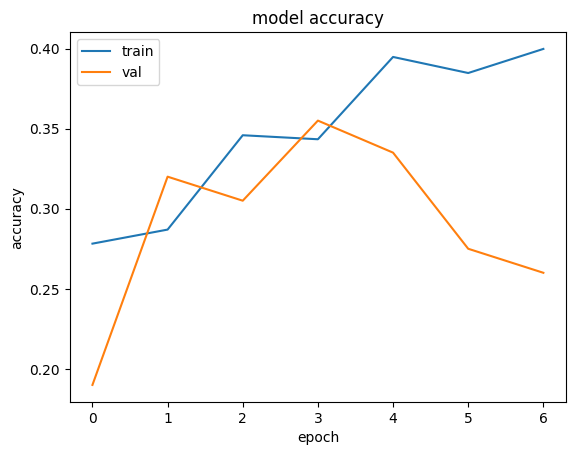

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

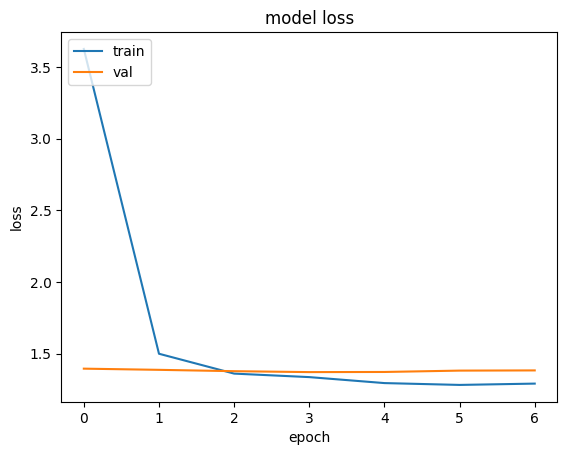

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score

test_hat =  EfficientNetB2_model.predict(test)
test_hat = np.argmax(test_hat, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_report = [labels[k] for k in test_hat]

y_test = test_images.labels
print(classification_report(y_test, pred_report))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred_report)*100))

13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 777ms/step
                  precision    recall  f1-score   support

    MildDemented       0.30      0.34      0.32       112
ModerateDemented       0.58      0.09      0.15        79
     NonDemented       0.31      0.63      0.41       120
VeryMildDemented       0.00      0.00      0.00        75

        accuracy                           0.31       386
       macro avg       0.30      0.27      0.22       386
    weighted avg       0.30      0.31      0.25       386

Accuracy of the Model: 31.3%


# EfficientNet B1

In [21]:
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import EfficientNetB1

# Define input image shape
img_shape = (244, 244, 3)

# Load the pre-trained EfficientNetB1 model without the top classification layer
base_model = EfficientNetB1(
    include_top=False,         # Do not include the top classification layer
    weights="imagenet",        # Use pre-trained ImageNet weights
    input_shape=img_shape,     # Input shape
    pooling='max'              # Global max pooling after conv base
)

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
base_model.trainable = True

# Flag to start fine-tuning
set_trainable = False

# Unfreeze layers from a specific point onwards
for layer in base_model.layers:
    if layer.name == 'block6a_expand_conv':  # You can change this layer to whichever layer you want to unfreeze
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [23]:
EfficientNetB1_model = Sequential([
    tf.keras.layers.InputLayer(input_shape=img_shape),
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

EfficientNetB1_model.compile(
    Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

EfficientNetB1_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb1 (Functional)     │ (None, 1280)           │     6,575,239 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,739,723 (25.71 MB)

 Trainable params: 5,471,776 (20.87 MB)

 Non-trainable params: 1,267,947 (4.84 MB)

In [24]:
# List all available physical devices
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    print("GPU is available:")
    for device in physical_devices:
        print(f"  - {device}")
else:
    print("GPU is NOT available. Using CPU.")

from tensorflow.python.client import device_lib

# Print available devices
print("Available devices:")
for device in device_lib.list_local_devices():
    print(f"  - {device.name} ({device.device_type})")

GPU is available:
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Available devices:
  - /device:CPU:0 (CPU)
  - /device:GPU:0 (GPU)


In [25]:
# Move the model to the GPU if available
with tf.device('/GPU:0'): # Or '/GPU:1' etc. if you have multiple GPUs. If no GPU, defaults to CPU.
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )
    history = EfficientNetB1_model.fit(
        train,
        epochs=50,
        validation_data=val,
        callbacks=[early_stopping, annealer]
    )


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.2643 - loss: 5.6077 - val_accuracy: 0.2450 - val_loss: 1.3946 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - accuracy: 0.2471 - loss: 1.4951 - val_accuracy: 0.1950 - val_loss: 1.4025 - learning_rate: 9.5000e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.2654 - loss: 1.4386 - val_accuracy: 0.3100 - val_loss: 1.3829 - learning_rate: 9.0250e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - accuracy: 0.2731 - loss: 1.4151 - val_accuracy: 0.3100 - val_loss: 1.3766 - learning_rate: 8.5737e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - accuracy: 0.3033 - loss: 1.3817 - val_accuracy: 0.3200 - val_loss: 1.3701 - learning_rate: 8.1451e-04
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.3065 - loss: 1.3894 - val_accuracy: 0.3250 - val_loss: 1.3739 - learning_rate: 7.7378e-04
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - accuracy: 0.339

In [26]:
train_loss, train_accuracy =  EfficientNetB1_model.evaluate(train)
print(f'\nTrain loss: {train_loss:.2f}')
print(f'Train Accuracy: {train_accuracy*100:.2f} %')

val_loss, val_accuracy =  EfficientNetB1_model.evaluate(val)
print(f'\nvalidation loss: {val_loss:.2f}')
print(f'Validation Accuracy: {val_accuracy*100:.2f} %')

test_loss, test_accuracy =  EfficientNetB1_model.evaluate(test)
print(f'\ntest loss: {test_loss:.2f}')
print(f'test Accuracy: {test_accuracy*100:.2f} %')

25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 314ms/step - accuracy: 0.3242 - loss: 1.3664

Train loss: 1.37
Train Accuracy: 31.83 %
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.3172 - loss: 1.3710

validation loss: 1.37
Validation Accuracy: 32.00 %
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 585ms/step - accuracy: 0.1800 - loss: 1.3822

test loss: 1.37
test Accuracy: 31.35 %


In [27]:
result = EfficientNetB1_model.evaluate(test, verbose=1)
print(result)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.1800 - loss: 1.3822
[1.366021990776062, 0.3134714961051941]


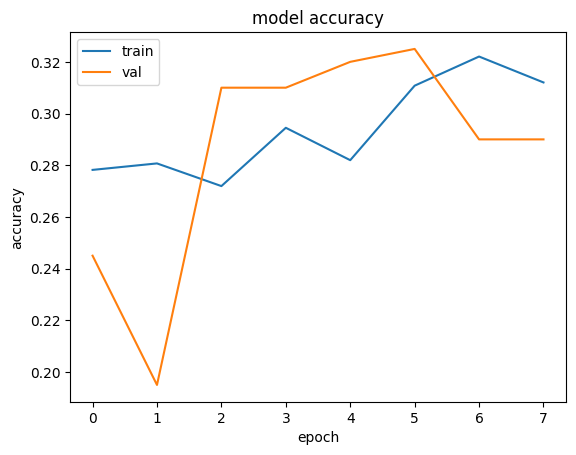

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

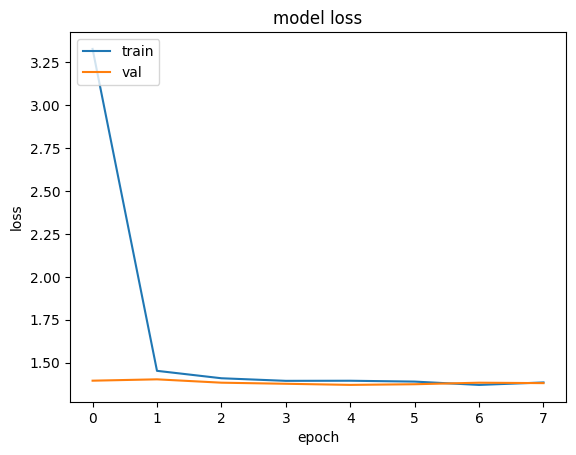

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score

test_hat =  EfficientNetB1_model.predict(test)
test_hat = np.argmax(test_hat, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_report = [labels[k] for k in test_hat]

y_test = test_images.labels
print(classification_report(y_test, pred_report))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred_report)*100))

13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 851ms/step
                  precision    recall  f1-score   support

    MildDemented       0.33      0.02      0.03       112
ModerateDemented       0.00      0.00      0.00        79
     NonDemented       0.31      0.99      0.48       120
VeryMildDemented       0.00      0.00      0.00        75

        accuracy                           0.31       386
       macro avg       0.16      0.25      0.13       386
    weighted avg       0.19      0.31      0.16       386

Accuracy of the Model: 31.3%
